---
## Contents

1. [Libraries and Installations](#Libraries-and-Installations)
1. [Configs](#Configs)
1. [Batch transform](#Batch-Transform)
    1. [Fit the train data](#Batch-transform-FIT)
    1. [Transform the train data](#Batch-transform-TRANSFORM)
    1. [Transform the test data](#Batch-Transform-TRANSFORM-test)
    1. [Upload processed data to s3](#upload-processed-train-test)
1. [Train, Track and Debug](#Train-Track-Debug)
    1. [Pre-Processing Tracker](#Pre-Processing-Tracker)
    1. [Create Experiment](#Create-Experiment)
	1. [Hyper-Parameter Train](#Train)
	1. [List Train Jobs](#List-Train-Jobs)
	1. [Best Training Job](#Best-Training-Job)
	1. [Lineage](#Lineage)
1. [Get Best Model](#Get-Best-Model)
1. [Explain Best Model](#Explain-Best-Model)
	1. [Load Best Model Tensors](#Load-Best-Model-Tensors)
    1. [Metrics - VIZ](#Metrics-VIZ)
	1. [Weight - VIZ](#Weight-VIZ)
	1. [Cover - VIZ](#Cover-VIZ)
	1. [Average SHAP - VIZ](#Average-SHAP-VIZ)
	1. [Global explanations](#Global-explanations)
	1. [Local explanations](#Local-explanations)
    1. [Local explanations, for a record](#Local-explanations-for-a-record)
	1. [Stacked force plot](#Stacked-force-plot)
	1. [Outlier](#Outlier)
1. [Deploy endpoint for the best training-job / trial component](#Deploy-endpoint)
1. [Make a request to our pipeline endpoint](#Request-Endpoint)
1. [Delete Endpoint](#Delete-Endpoint)
1. [Delete Experiments](#Delete-Experiments)
---

## 1. Libraries and Installations <a class="anchor" id="Libraries-and-Installations"></a>

In [12]:
!pip install sagemaker-experiments
!pip install s3fs
!pip install matplotlib
!pip install seaborn
!pip install shap
!pip install smdebug

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [13]:
from io import StringIO
import numpy as np
import os
import pandas as pd
import boto3
import time
import s3fs
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import re
import shap
from scipy import stats
import copy

In [14]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

from sagemaker.sklearn.estimator import SKLearn
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
from sagemaker.session import s3_input
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import Session

from smdebug.trials import create_trial

## 2. Configs <a class="anchor" id="Configs"></a>

In [15]:
now = datetime.now()

current_time = now.strftime("%Y-%m-%d--%H-%M-%S")
# dd/mm/YY H:M:S format
print("current_time:", current_time)

current_time: 2020-08-18--11-43-38


In [16]:
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# S3 prefix
bucket = 'ta-sagemaker-experiments'
prefix = 'Scikit-pre-model-Inference-Pipelines'

#dataset = 's3://ta-sagemaker-experiments/housing/datasets/housing_dataset.csv'
train_data= 's3://ta-sagemaker-experiments/housing/input-datasets/train_data_without_header.csv'
test_data= 's3://ta-sagemaker-experiments/housing/input-datasets/test_data_without_header.csv'

FRAMEWORK_VERSION = "0.23-1"
script_path = 'sklearn_pipeline.py'
dependancy_path = 'dependancies.py'

base_job_name = f"Builtin-XGB-algo-{current_time}"


output_data_prefix = f'housing/datasets/output/{base_job_name}'
data_output_path = f's3://{bucket}/{output_data_prefix}'

debug_prefix = f'housing/jobs/debug/{base_job_name}'
debug_path = f's3://{bucket}/{debug_prefix}'

experiment_name_prefix = "builtin-xgboost-track13"

In [17]:
train_data

's3://ta-sagemaker-experiments/housing/input-datasets/train_data_without_header.csv'

## 3. Batch transform  <a class="anchor" id="Batch-Transform"></a>

### 3.1. Fit the train data  <a class="anchor" id="Batch-transform-FIT"></a>

In [18]:
sklearn_preprocessor = SKLearn(
    entry_point=script_path,
    role=role,
    framework_version=FRAMEWORK_VERSION,
    train_instance_type="ml.m5.xlarge",
    train_use_spot_instances=True,
    train_max_run = 600,
    train_max_wait = 1200,
    dependencies=[dependancy_path],
    sagemaker_session=sagemaker_session
    
)

In [19]:
role

'arn:aws:iam::171774164293:role/service-role/AmazonSageMaker-ExecutionRole-20200608T073821'

In [20]:
sklearn_preprocessor.fit(
    inputs={'train': train_data},
    job_name=base_job_name
)

INFO:sagemaker:Creating training-job with name: Builtin-XGB-algo-2020-08-18--11-43-38


2020-08-18 11:43:39 Starting - Starting the training job...
2020-08-18 11:43:41 Starting - Launching requested ML instances............
2020-08-18 11:45:56 Starting - Preparing the instances for training...
2020-08-18 11:46:37 Downloading - Downloading input data
2020-08-18 11:46:37 Training - Downloading the training image......
2020-08-18 11:47:35 Training - Training image download completed. Training in progress..2020-08-18 11:47:35,423 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-08-18 11:47:35,425 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-18 11:47:35,435 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-08-18 11:47:35,737 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-18 11:47:41,969 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-18 11:47:41,979 sagemaker-training

### 3.2. Transform the train data  <a class="anchor" id="Batch-transform-TRANSFORM"></a>

In [21]:
transformer = sklearn_preprocessor.transformer(
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    assemble_with = 'Line',
    accept = 'text/csv',
    output_path=data_output_path
)

INFO:sagemaker:Creating model with name: Builtin-XGB-algo-2020-08-18--11-43-38


In [22]:
transformer.transform(
    data=train_data, 
    content_type="text/csv",
    job_name=base_job_name+'-train'
)
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2020-08-18--11-43-38-train


Waiting for transform job: Builtin-XGB-algo-2020-08-18--11-43-38-train
..............................
2020-08-18 11:53:12,422 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-08-18 11:53:12,424 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-08-18 11:53:12,425 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read

In [23]:
preprocessed_train_data = transformer.output_path

In [24]:
preprocessed_train_data

's3://ta-sagemaker-experiments/housing/datasets/output/Builtin-XGB-algo-2020-08-18--11-43-38'

### 3.3. Transform the test data <a class="anchor" id="Batch-Transform-TRANSFORM-test"></a>

In [25]:
transformer.transform(
    data=test_data, 
    content_type="text/csv",
    job_name=base_job_name+'-test'
)
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2020-08-18--11-43-38-test


Waiting for transform job: Builtin-XGB-algo-2020-08-18--11-43-38-test
............................2020-08-18 11:58:06,725 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-08-18 11:58:06,727 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-08-18 11:58:06,728 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_tim

In [26]:
preprocessed_test_data = transformer.output_path

In [27]:
f'{output_data_prefix}'

'housing/datasets/output/Builtin-XGB-algo-2020-08-18--11-43-38'

### 3.4. Upload processed data to s3  <a class="anchor" id="upload-processed-train-test"></a>

In [28]:
client = boto3.client('s3') 
obj = client.get_object(Bucket=bucket, Key=f'{output_data_prefix}/train_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_train_data = pd.read_csv(StringIO(csv_string))

In [29]:
train_file = 'processed_train_data.csv'
processed_train_data.to_csv(train_file,index=False,header=False)
with open(train_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-train',train_file))

In [30]:
obj = client.get_object(Bucket=bucket, Key=f'{output_data_prefix}/test_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_test_data = pd.read_csv(StringIO(csv_string))

test_file = 'processed_test_data.csv'
processed_test_data.to_csv(test_file,index=False,header=False)
with open(test_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-test',test_file))

## 4. Train, Track and Debug <a class="anchor" id="Train-Track-Debug"></a>

In [31]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()
region = "us-east-1"

In [32]:
container = get_image_uri(region, "xgboost", repo_version="0.90-2")

In [33]:
save_interval = 2

In [34]:
prefix

'Scikit-pre-model-Inference-Pipelines'

In [35]:
content_type = "text/csv"
train_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-train/processed_train_data.csv", content_type=content_type)
validation_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-test/processed_test_data.csv", content_type=content_type)

In [36]:
train_df = pd.read_csv(f"s3://{bucket}/{output_data_prefix}/processed-train/processed_train_data.csv")

### 4.1. Pre-Processing Tracker <a class="anchor" id="Pre-Processing-Tracker"></a>

In [37]:
with Tracker.create(display_name="Pre-Processing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "Num_Imputer" : "SimpleImputer",
        "Num_Norm"    : "StandardScaler",
        "Cat_Norm"    : "SimpleImputer",
        "Cat_Convert" : "OneHotEncoder",
        "No_of_rows"  : str(len(train_df))
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="xgboost-track", media_type="s3/uri", value=f"s3://{bucket}/{output_data_prefix}/processed-train/processed_train_data.csv")

### 4.2. Create Experiment <a class="anchor" id="Create-Experiment"></a>

In [38]:
xgboost_experiment = Experiment.create(
    experiment_name=f"{experiment_name_prefix}-{int(time.time())}", 
    description="xgboost-track", 
    sagemaker_boto_client=sm)
print(xgboost_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f1d86bb8a90>,experiment_name='builtin-xgboost-track13-1597751933',description='xgboost-track',experiment_arn='arn:aws:sagemaker:us-east-1:171774164293:experiment/builtin-xgboost-track13-1597751933',response_metadata={'RequestId': '50949c28-01cd-4fce-b50b-105f0dfb3104', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '50949c28-01cd-4fce-b50b-105f0dfb3104', 'content-type': 'application/x-amz-json-1.1', 'content-length': '106', 'date': 'Tue, 18 Aug 2020 11:58:52 GMT'}, 'RetryAttempts': 0})


In [39]:
trial_name_map = {}

In [40]:
trial_component = tracker.trial_component

In [41]:
debug_path

's3://ta-sagemaker-experiments/housing/jobs/debug/Builtin-XGB-algo-2020-08-18--11-43-38'

### 4.3. Train <a class="anchor" id="Train"></a>

In [42]:
for i, eta in enumerate([0.3, 0.4, 0.5]):
    for j, max_depth in enumerate([2, 4, 6]):
        base_name = f"xbg-eta-{str(eta).replace('.', '-')}-max-depth-{str(max_depth).replace('.', '-')}"
        time_val = f"time-{int(time.time())}"
        trial_name = base_name + "-" + time_val
        xgb_trial = Trial.create(
            trial_name=trial_name, 
            experiment_name=xgboost_experiment.experiment_name,
            sagemaker_boto_client=sm,
        )
        trial_name_map[(eta,max_depth)] = trial_name

        # associate the proprocessing trial component with the current trial
        xgb_trial.add_trial_component(trial_component)

        xgboost_estimator = Estimator(
            role=role,
            base_job_name=trial_name,
            train_instance_count=1,
            train_instance_type='ml.m5.xlarge',
            image_name=container,
            hyperparameters={
                "max_depth": str(max_depth),
                "eta": str(eta),
                "gamma": "4",
                "min_child_weight": "6",
                "subsample": "0.7",
                "silent": "0",
                "eval_metric":"rmse",
                "objective": "reg:linear",
                "num_round": "51",
            },
    #         metric_definitions=[
    #             {'Name':'train:rmse', 'Regex':'Train RMSE: (.*?);'},
    #             {'Name':'validation:rmse', 'Regex':'Validation RMSE: (.*?)%;'}
    #         ],
            enable_sagemaker_metrics=True,
            train_use_spot_instances=True,
            train_max_run = 600,
            train_max_wait = 1200,
            
            debugger_hook_config=DebuggerHookConfig(
            s3_output_path=debug_path,  # Required
            collection_configs=[
                    CollectionConfig(
                        name="metrics",
                        parameters={
                            "save_interval": str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="feature_importance",
                        parameters={
                            "save_interval": str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="full_shap",
                        parameters={
                            "save_interval": str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="average_shap",
                        parameters={
                            "save_interval": str(save_interval)
                        }
                    ),
                ],
            ),

            rules=[
                Rule.sagemaker(
                    rule_configs.loss_not_decreasing(),
                    rule_parameters={
                        "collection_names": "metrics",
                        "num_steps": str(save_interval * 2),
                    },
                ),
            ],
        )

        xgb_training_job_name = "xgb-training-job-{}".format(int(time.time()))

        xgboost_estimator.fit(
            {"train": train_input, "validation": validation_input},
            # This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
            # Amazon SageMaker starts one training job and release control to next cells in the notebook.
            # Follow this notebook to see status of the training job.
            experiment_config={
                "TrialName": xgb_trial.trial_name,
                "TrialComponentDisplayName": "Training",
            },
            wait=False
        )

        # give it a while before dispatching the next training job
        time.sleep(4)

INFO:sagemaker:Creating training-job with name: xbg-eta-0-3-max-depth-2-time-1597751933-2020-08-18-11-58-53-946
INFO:sagemaker:Creating training-job with name: xbg-eta-0-3-max-depth-4-time-1597751938-2020-08-18-11-58-58-482
INFO:sagemaker:Creating training-job with name: xbg-eta-0-3-max-depth-6-time-1597751942-2020-08-18-11-59-03-111
INFO:sagemaker:Creating training-job with name: xbg-eta-0-4-max-depth-2-time-1597751947-2020-08-18-11-59-07-832
INFO:sagemaker:Creating training-job with name: xbg-eta-0-4-max-depth-4-time-1597751952-2020-08-18-11-59-12-480
INFO:sagemaker:Creating training-job with name: xbg-eta-0-4-max-depth-6-time-1597751956-2020-08-18-11-59-17-129
INFO:sagemaker:Creating training-job with name: xbg-eta-0-5-max-depth-2-time-1597751961-2020-08-18-11-59-21-905
INFO:sagemaker:Creating training-job with name: xbg-eta-0-5-max-depth-4-time-1597751966-2020-08-18-11-59-26-369
INFO:sagemaker:Creating training-job with name: xbg-eta-0-5-max-depth-6-time-1597751970-2020-08-18-11-59

### 4.4. List Train Jobs <a class="anchor" id="List-Train-Jobs"></a>

In [43]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [44]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=xgboost_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.validation:rmse.max",
    sort_order="Descending",
    metric_names=['validation:rmse'],
    parameter_names=['max_depth', 'eta', 'silent', 'gamma']
)

In [45]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,eta,gamma,max_depth,silent,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,validation:rmse - StdDev,validation:rmse - Last,validation:rmse - Count
0,xbg-eta-0-3-max-depth-2-time-1597751933-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,2.0,0.0,55452.9,175980.0,66004.723529,21425.813278,55452.9,51
1,xbg-eta-0-3-max-depth-4-time-1597751938-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,4.0,0.0,51861.3,173662.0,68498.321739,30137.625547,51861.3,23
2,xbg-eta-0-3-max-depth-6-time-1597751942-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,6.0,0.0,47335.2,172388.0,55585.043137,21944.530951,47465.6,51
3,xbg-eta-0-4-max-depth-2-time-1597751947-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,2.0,0.0,54829.0,156995.0,64822.138462,18863.648537,54913.7,39
4,xbg-eta-0-4-max-depth-4-time-1597751952-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,4.0,0.0,49040.4,153648.0,56127.802128,17657.679755,49040.4,47
5,xbg-eta-0-4-max-depth-6-time-1597751956-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,6.0,0.0,48542.0,151848.0,55007.304651,17944.135184,48699.2,43
6,xbg-eta-0-5-max-depth-2-time-1597751961-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,2.0,0.0,55496.8,138880.0,63247.243590,14771.098702,55496.8,39
7,xbg-eta-0-5-max-depth-4-time-1597751966-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,4.0,0.0,49047.9,134309.0,54372.370588,13175.686540,49047.9,51
8,xbg-eta-0-5-max-depth-6-time-1597751970-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,6.0,0.0,49480.1,131906.0,55864.337037,16794.668241,49517.4,27


### 4.5. Best Training Job <a class="anchor" id="Best-Training-Job"></a>

In [46]:
result_df = trial_component_analytics.dataframe(force_refresh=True).sort_values(["validation:rmse - StdDev", "validation:rmse - Avg"]).reset_index(drop=True)

In [47]:
result_df

,TrialComponentName,DisplayName,SourceArn,eta,gamma,max_depth,silent,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,validation:rmse - StdDev,validation:rmse - Last,validation:rmse - Count
0,xbg-eta-0-5-max-depth-4-time-1597751966-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,4.0,0.0,49047.9,134309.0,54372.370588,13175.686540,49047.9,51
1,xbg-eta-0-5-max-depth-2-time-1597751961-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,2.0,0.0,55496.8,138880.0,63247.243590,14771.098702,55496.8,39
2,xbg-eta-0-5-max-depth-6-time-1597751970-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.5,4.0,6.0,0.0,49374.7,131906.0,55041.751613,15785.216174,49516.0,31
3,xbg-eta-0-4-max-depth-6-time-1597751956-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,6.0,0.0,48268.0,151848.0,53963.278431,16626.772218,48391.9,51
4,xbg-eta-0-4-max-depth-4-time-1597751952-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,4.0,0.0,49040.4,153648.0,56127.802128,17657.679755,49040.4,47
5,xbg-eta-0-4-max-depth-2-time-1597751947-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.4,4.0,2.0,0.0,54829.0,156995.0,64822.138462,18863.648537,54913.7,39
6,xbg-eta-0-3-max-depth-2-time-1597751933-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,2.0,0.0,55452.9,175980.0,66004.723529,21425.813278,55452.9,51
7,xbg-eta-0-3-max-depth-6-time-1597751942-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,6.0,0.0,47335.2,172388.0,55585.043137,21944.530951,47465.6,51
8,xbg-eta-0-3-max-depth-4-time-1597751938-2020-0...,Training,arn:aws:sagemaker:us-east-1:171774164293:train...,0.3,4.0,4.0,0.0,51861.3,173662.0,68498.321739,30137.625547,51861.3,23


In [48]:
best_trial_component_name = result_df.iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

In [49]:
print(best_trial_component.parameters['max_depth'])
print(best_trial_component.parameters['eta'])
print(best_trial_component.parameters['min_child_weight'])

4.0
0.5
6.0


In [50]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-5-max-depth-4-time-1597751966-2020-08-18-11-59-26-369'

### 4.6. Lineage <a class="anchor" id="Lineage"></a>

In [51]:
trial_name_map

{(0.3, 2): 'xbg-eta-0-3-max-depth-2-time-1597751933',
 (0.3, 4): 'xbg-eta-0-3-max-depth-4-time-1597751938',
 (0.3, 6): 'xbg-eta-0-3-max-depth-6-time-1597751942',
 (0.4, 2): 'xbg-eta-0-4-max-depth-2-time-1597751947',
 (0.4, 4): 'xbg-eta-0-4-max-depth-4-time-1597751952',
 (0.4, 6): 'xbg-eta-0-4-max-depth-6-time-1597751956',
 (0.5, 2): 'xbg-eta-0-5-max-depth-2-time-1597751961',
 (0.5, 4): 'xbg-eta-0-5-max-depth-4-time-1597751966',
 (0.5, 6): 'xbg-eta-0-5-max-depth-6-time-1597751970'}

In [52]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name_map[(0.5, 6)]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_table.dataframe()

,TrialComponentName,DisplayName,Cat_Convert,Cat_Norm,No_of_rows,Num_Imputer,Num_Norm,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,...,train:rmse - Avg,train:rmse - StdDev,train:rmse - Last,train:rmse - Count,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,validation:rmse - StdDev,validation:rmse - Last,validation:rmse - Count
0,TrialComponent-2020-08-18-115853-zwxm,Pre-Processing,OneHotEncoder,SimpleImputer,16553,SimpleImputer,StandardScaler,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xbg-eta-0-5-max-depth-6-time-1597751970-2020-0...,Training,NaN,NaN,NaN,NaN,NaN,arn:aws:sagemaker:us-east-1:171774164293:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,...,43800.405882,14814.815282,34061.5,51.0,49035.2,131906.0,52789.496078,12551.402607,49117.2,51.0


## 5. Get Best Model <a class="anchor" id="Get-Best-Model"></a>

In [53]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime
from sagemaker.estimator import Estimator
from sagemaker import PipelineModel

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
scikit_learn_inferencee_model.env = {"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT":"text/csv"}
algo_estimator = Estimator.attach(best_trial_component.source.source_arn.split("/")[-1])
best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

# Final pipeline model is composed of data transformation models and algo model and an
# inverse label transform model if we need to transform the intermediates back to non-numerical value
model_containers = [scikit_learn_inferencee_model, best_algo_model]

2020-08-18 12:03:54 Starting - Preparing the instances for training
2020-08-18 12:03:54 Downloading - Downloading input data
2020-08-18 12:03:54 Training - Training image download completed. Training in progress.
2020-08-18 12:03:54 Uploading - Uploading generated training model
2020-08-18 12:03:54 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[12:03:01] 16554x16 matrix with 2648

## 6. Explain Best Model <a class="anchor" id="Explain-Best-Model"></a>

### 6.1. Load Best Model Tensors <a class="anchor" id="Load-Best-Model-Tensors"></a>

In [54]:
algo_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:171774164293:processing-job/xbg-eta-0-5-max-depth-4-ti-lossnotdecreasing-471ba0a6',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2020, 8, 18, 12, 4, 35, 10000, tzinfo=tzlocal())}]

In [55]:
algo_estimator.latest_job_debugger_artifacts_path()

In [56]:
best_model_track_path = os.path.join(
    debug_path, 
    best_trial_component.source.source_arn.split("/")[-1],
    "debug-output"
)
best_model_track_path

's3://ta-sagemaker-experiments/housing/jobs/debug/Builtin-XGB-algo-2020-08-18--11-43-38/xbg-eta-0-5-max-depth-4-time-1597751966-2020-08-18-11-59-26-369/debug-output'

In [57]:
trial = create_trial(best_model_track_path)

[2020-08-18 12:04:47.491 fdd0433127a5:712 INFO s3_trial.py:42] Loading trial debug-output at path s3://ta-sagemaker-experiments/housing/jobs/debug/Builtin-XGB-algo-2020-08-18--11-43-38/xbg-eta-0-5-max-depth-4-time-1597751966-2020-08-18-11-59-26-369/debug-output


In [58]:
trial.tensor_names()

[2020-08-18 12:04:50.550 fdd0433127a5:712 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-08-18 12:04:51.572 fdd0433127a5:712 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f11',
 'feature_importance/gain/f12',
 'feature_importance/gain/f14',
 'feature_importance/gain/f15',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/gain/f9',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f10',
 'feature_importance/total_cover/f11',
 'feature_importance/total_cover/f12',
 'feature_importance/total_cover/f14',
 'feature_importance/total_cover/f15',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_cover/f4',
 'feature_importance/total_cover/f5',
 'feature_importance/total_cover/f6',
 'feature_importance/total_cover/f7',
 'feature_importance/total_cover/f8',
 'feature_importance/total_cover/f9',
 'feature_importance/total_gain/f0',
 'feature_importance/total_gain/f1',
 'feature_importance/total_gain/f10',
 'feature_importance/total_gain/f11',
 'feature_importance/total_gain/f12',
 'feature_importance/total_gain/f14',
 'feature_importance/total_gain/f15',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f3',
 'feature_importance/total_gain/f4',
 'feature_importance/total_gain/f5',
 'feature_importance/total_gain/f6',
 'feature_importance/total_gain/f7',
 'feature_importance/total_gain/f8',
 'feature_importance/total_gain/f9',
 'feature_importance/weight/f0',
 'feature_importance/weight/f1',
 'feature_importance/weight/f10',
 'feature_importance/weight/f11',
 'feature_importance/weight/f12',
 'feature_importance/weight/f14',
 'feature_importance/weight/f15',
 'feature_importance/weight/f2',
 'feature_importance/weight/f3',
 'feature_importance/weight/f4',
 'feature_importance/weight/f5',
 'feature_importance/weight/f6',
 'feature_importance/weight/f7',
 'feature_importance/weight/f8',
 'feature_importance/weight/f9',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f10',
 'full_shap/f11',
 'full_shap/f12',
 'full_shap/f13',
 'full_shap/f14',
 'full_shap/f15',
 'full_shap/f2',
 'full_shap/f3',
 'full_shap/f4',
 'full_shap/f5',
 'full_shap/f6',
 'full_shap/f7',
 'full_shap/f8',
 'full_shap/f9',
 'train-rmse',
 'validation-rmse']

In [59]:
trial.tensor("train-rmse").steps()

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50]

In [60]:
trial.tensor("validation-rmse").values()

{0: array([134309.421875]),
 2: array([71427.179688]),
 4: array([59709.570312]),
 6: array([56169.535156]),
 8: array([54409.183594]),
 10: array([53610.117188]),
 12: array([52437.371094]),
 14: array([52072.097656]),
 16: array([52058.410156]),
 18: array([51810.433594]),
 20: array([51639.683594]),
 22: array([51403.003906]),
 24: array([50963.816406]),
 26: array([50641.054688]),
 28: array([50619.472656]),
 30: array([50514.65625]),
 32: array([50503.269531]),
 34: array([50470.628906]),
 36: array([50059.585938]),
 38: array([49994.566406]),
 40: array([49704.347656]),
 42: array([49484.351562]),
 44: array([49433.246094]),
 46: array([49215.847656]),
 48: array([49121.535156]),
 50: array([49047.945312])}

In [61]:
trial.tensor("validation-rmse").steps()

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50]

In [62]:
{i for i in  trial.tensor_names() if "average_shap" in i}

{'average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9'}

In [63]:
feature_names = [
    'longitude',
    'latitude', 
    'housing_median_age', 
    'total_rooms', 
    'total_bedrooms', 
    'population',
    'households', 
    'median_income',
    'rooms_per_household', 
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN', 
    'INLAND', 
    'ISLAND', 
    'NEAR BAY', 
    'NEAR OCEAN'
]

In [64]:
def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    print(collection_name)
    #tensors = trial.collection(collection_name).tensor_names
    #{i for i in  trial.tensor_names() if "feature_importance" in i}
    if(collection_name == "metrics"):
        tensors = trial.collection(collection_name).tensor_names
    else:
        tensors = {i for i in  trial.tensor_names() if collection_name in i}

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            if(len(tensors)) == 2:
                label=tensor_name
            else:
                label=tensor_name+"-"+feature_names[int(tensor_name.split("/")[-1].split("f")[1])]
            ax.plot(
                steps,
                data, 
                label=label
            )

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

In [65]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

### 6.2. Metrics - VIZ <a class="anchor" id="Metrics-VIZ"></a>

metrics


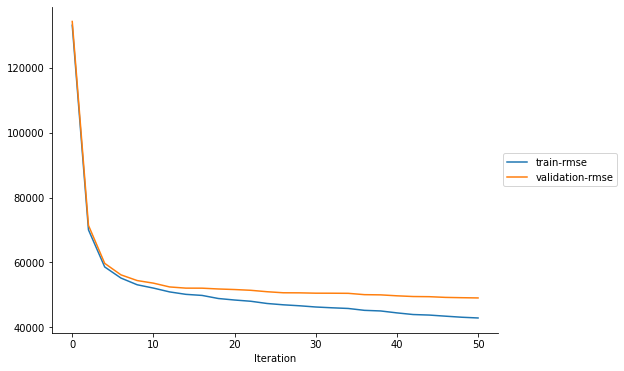

In [66]:
plot_collection(trial, "metrics")

### 6.3. Weight - VIZ <a class="anchor" id="Weight-VIZ"></a>

feature_importance


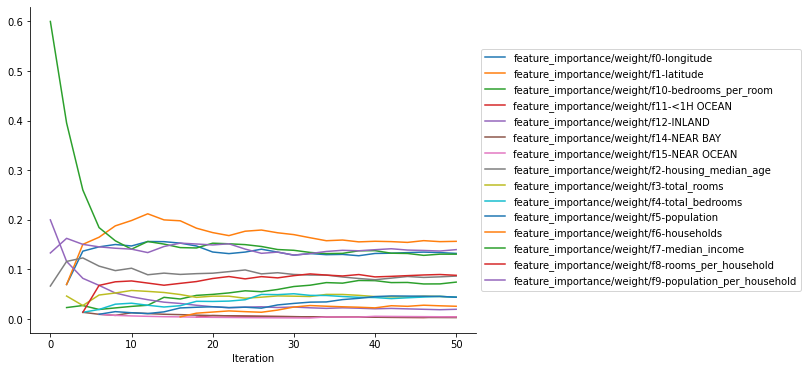

In [67]:
plot_feature_importance(trial, importance_type="weight")

### 6.4. Cover - VIZ <a class="anchor" id="Cover-VIZ"></a>

feature_importance


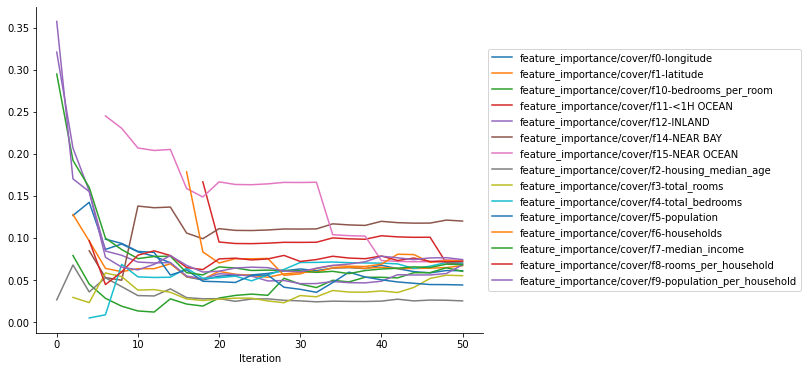

In [68]:
plot_feature_importance(trial, importance_type="cover")

### 6.5. Average SHAP - VIZ <a class="anchor" id="Average-SHAP-VIZ"></a>

average_shap


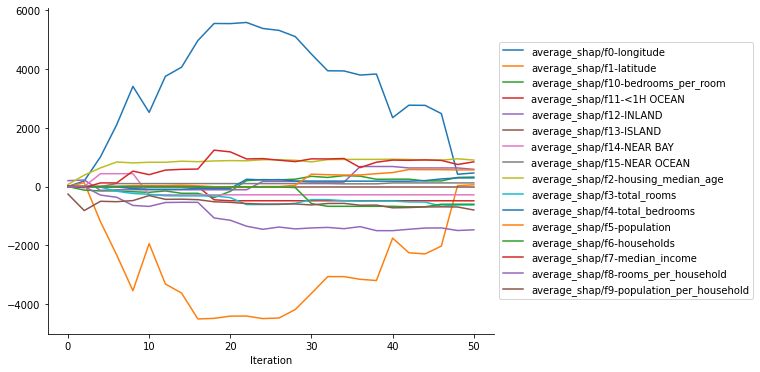

In [69]:
plot_collection(trial,"average_shap")

### 6.6. Global explanations <a class="anchor" id="Global-explanations"></a>

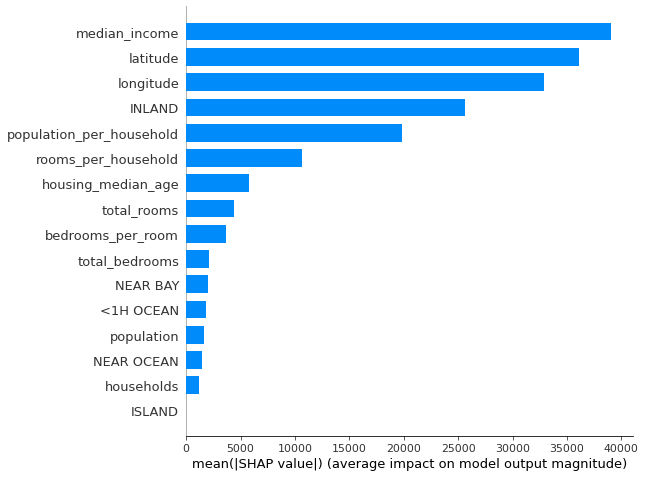

In [70]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [71]:
f"{data_output_path}"

's3://ta-sagemaker-experiments/housing/datasets/output/Builtin-XGB-algo-2020-08-18--11-43-38'

### 6.7. Local explanations <a class="anchor" id="Local-explanations"></a>

In [72]:
data = pd.read_csv(f"{data_output_path}/processed-train/processed_train_data.csv", header=None)
data.columns = ["median_house_value"] + feature_names

In [73]:
len(data.columns)

17

In [74]:
data.columns

Index(['median_house_value', 'longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')

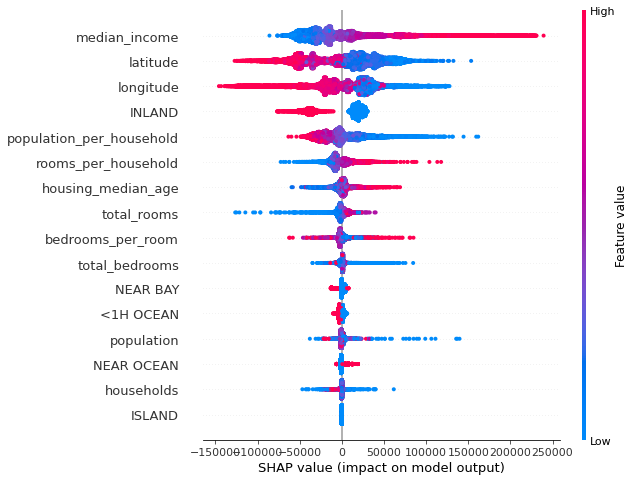

In [75]:
shap.summary_plot(shap_no_base, data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']], feature_names=feature_names)

### 6.8. Local explanations, for a record <a class="anchor" id="Local-explanations-for-a-record"></a>

In [76]:
shap.initjs()

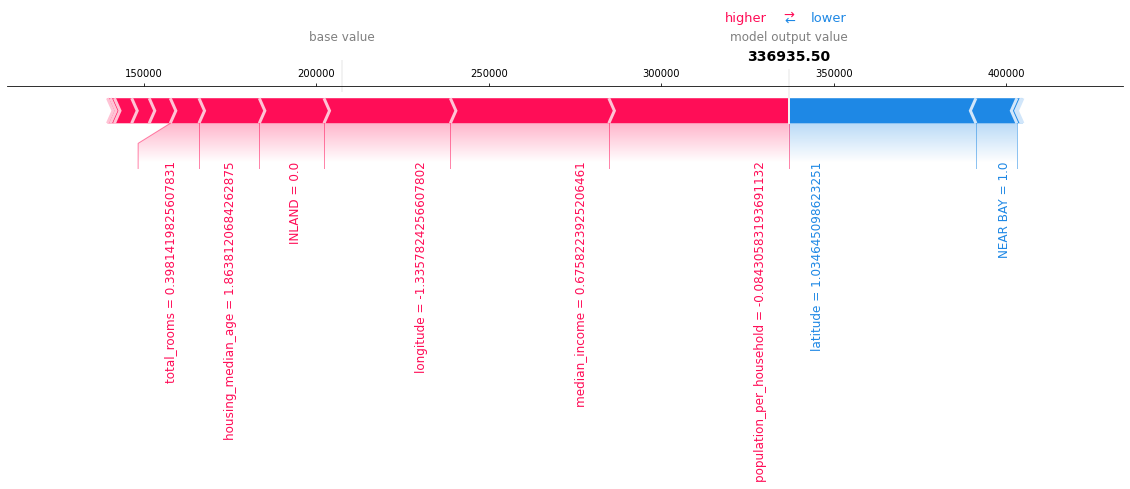

In [77]:
shap.force_plot(shap_base_value, shap_no_base[100, :],
                data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']].iloc[100, :], link="identity", matplotlib=True, text_rotation=90, figsize=(20, 3))

### 6.9. Stacked force plot <a class="anchor" id="Stacked-force-plot"></a>

In [78]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [79]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices, :],
                data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']].iloc[sampled_indices, :],
                link='identity')

### 6.10. Outlier <a class="anchor" id="Outlier"></a>

In [80]:
N_OUTLIERS = 3  # number of outliers on each side of the tail

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)
                   [-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)
                    [:N_OUTLIERS]).tolist()

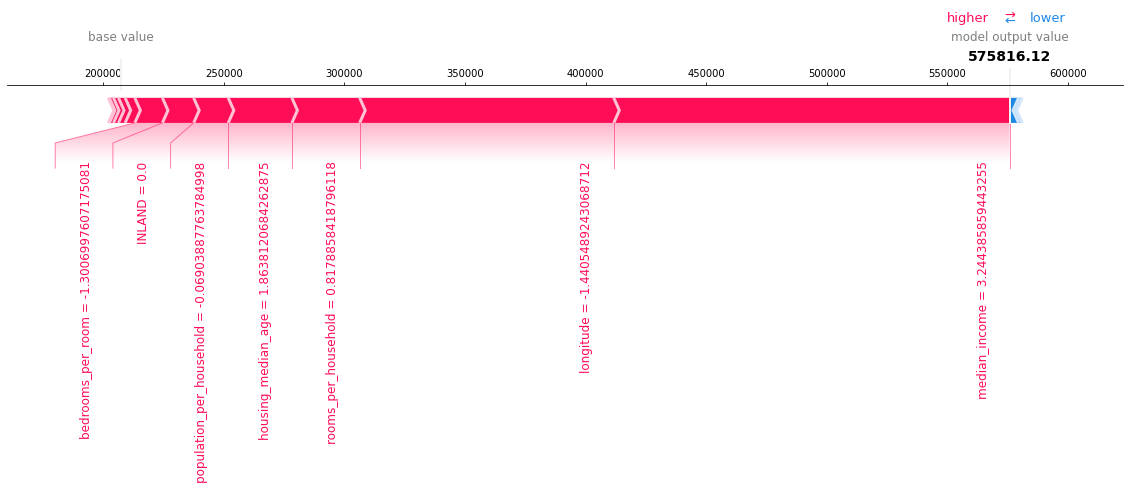

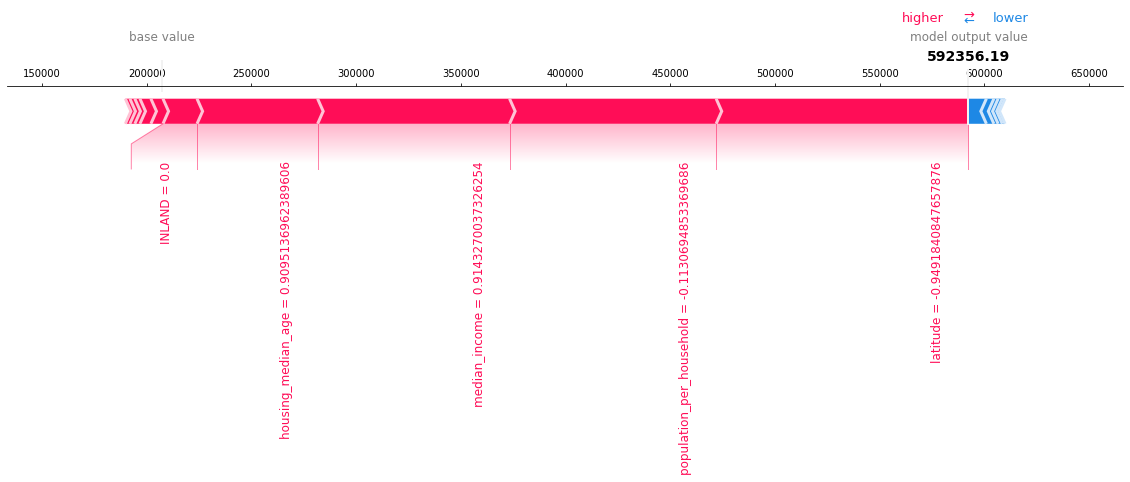

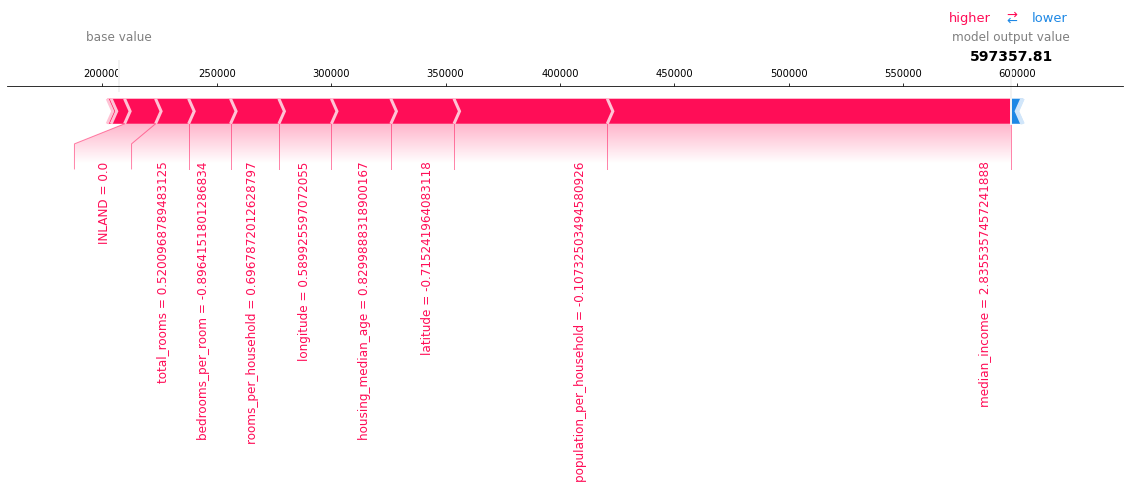

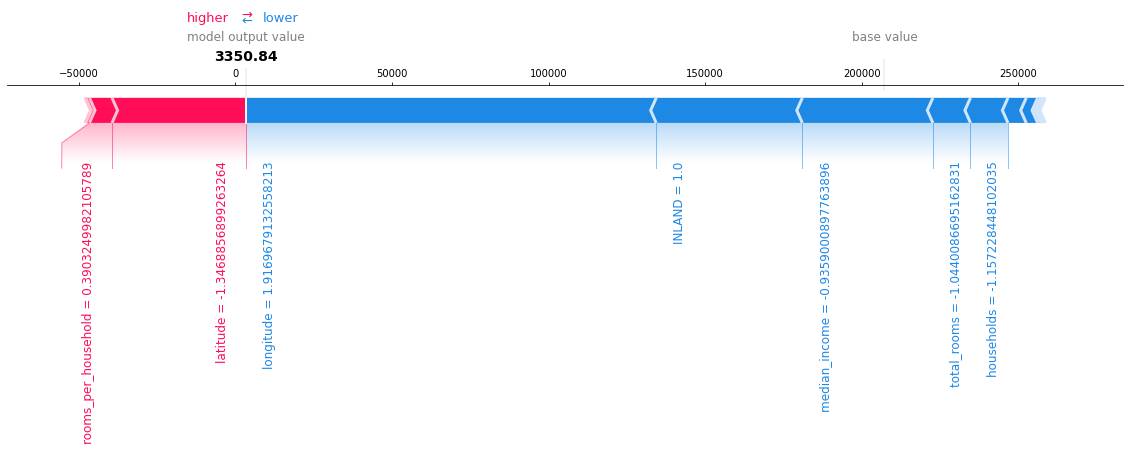

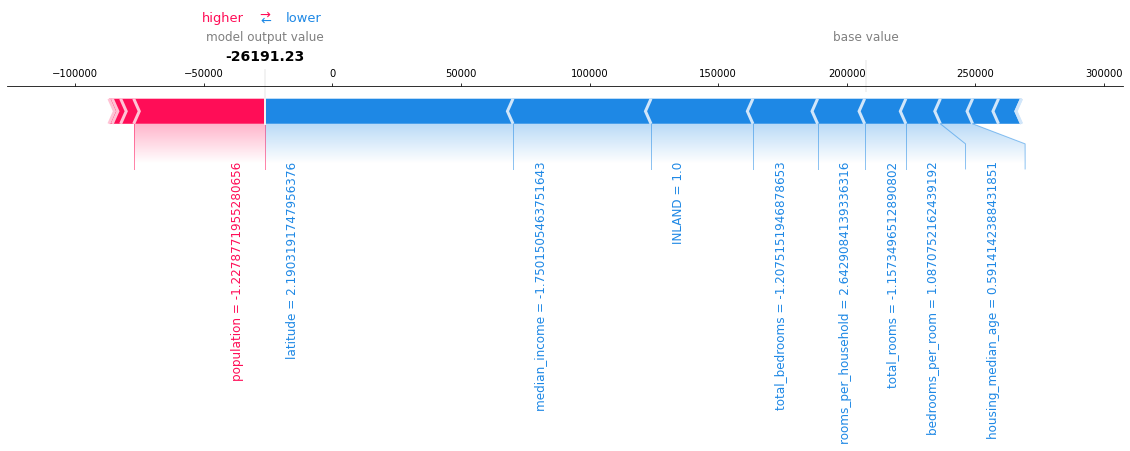

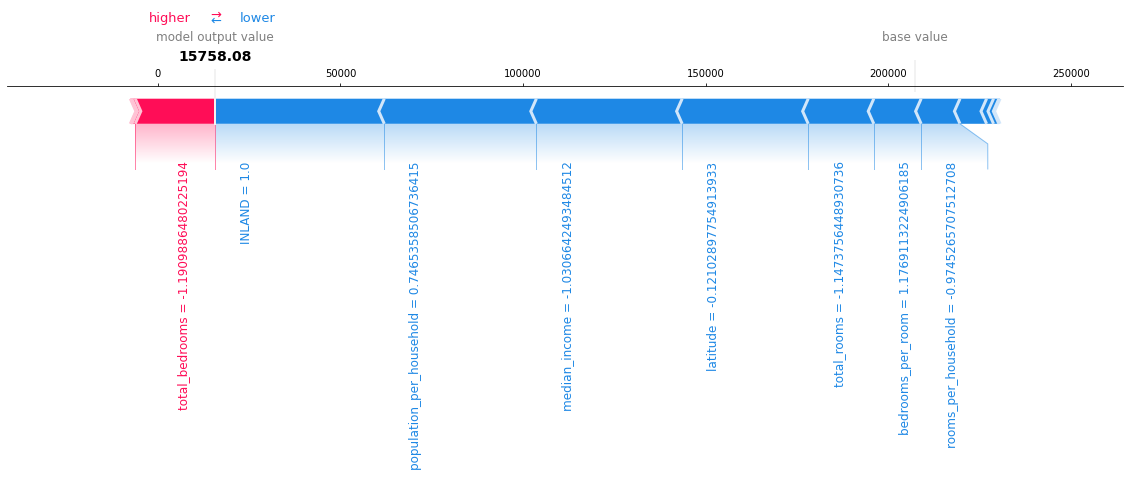

In [81]:
for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    shap.force_plot(shap_base_value,
                    shap_no_base[outlier_index, :],
                    data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']].iloc[outlier_index, :],
                    matplotlib=True,
                    link='identity', text_rotation=90, figsize=(20, 3))

## 7. Deploy endpoint for the best training-job / trial component <a class="anchor" id="Deploy-endpoint"></a>

In [82]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-5-max-depth-4-time-1597751966-2020-08-18-11-59-26-369'

In [83]:
f'{base_job_name}-Endpoint'

'Builtin-XGB-algo-2020-08-18--11-43-38-Endpoint'

In [84]:
bucket =  'ta-sagemaker-experiments'
#print("Bucket: {}".format(bucket))
prefix = 'ModelMonitor'

data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_prefix)

from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
                        enable_capture=True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path)

model_name = f'{base_job_name}-Model'
endpoint_name = f'{base_job_name}-Endpoint'

sm_model = PipelineModel(
    name=model_name, 
    role=role, 
    models=model_containers
)

predictor = sm_model.deploy(initial_instance_count=1,
                         instance_type='ml.m5.xlarge',
                         endpoint_name=endpoint_name,
                         data_capture_config=data_capture_config)

INFO:sagemaker:Creating model with name: Builtin-XGB-algo-2020-08-18--11-43-38-Model
INFO:sagemaker:Creating endpoint with name Builtin-XGB-algo-2020-08-18--11-43-38-Endpoint


-----------------!

In [85]:
endpoint_name

'Builtin-XGB-algo-2020-08-18--11-43-38-Endpoint'

## 8. Make a request to our pipeline endpoint <a class="anchor" id="Request-Endpoint"></a>

In [88]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
payload = """-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY"""

predictor = RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_CSV
)

In [89]:
print(predictor.predict(payload))

b'350954.28125,402274.8125'


## 10. Delete Endpoint  <a class="anchor" id="Delete-Endpoint"></a>

In [91]:
import sagemaker
sagemaker_session = sagemaker.Session()
endpoint_name='Builtin-XGB-algo-2020-08-18--04-21-15-Endpoint'
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'da32b995-2f6a-4b20-9e5c-707296c056c3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'da32b995-2f6a-4b20-9e5c-707296c056c3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 18 Aug 2020 12:22:02 GMT'},
  'RetryAttempts': 0}}

## 11. Delete Experiments <a class="anchor" id="Delete-Experiments"></a>

In [ ]:
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        trial.delete()
    experiment.delete()

cleanup(xgboost_experiment)